In [290]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import quandl
import sys
import scipy.optimize as scoplt
import datetime as dt              # working with dates
import json                        # parse json into a list
import requests                    # for "get" request to API

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff

plt.style.use('fivethirtyeight')
np.random.seed(777)
def get_binance_coin(symbol, startTime, endTime): 
    url = "https://api.binance.com/api/v3/klines"

    startTime = str(int(startTime.timestamp() * 1000))
    endTime = str(int(endTime.timestamp() * 1000))
    limit = '1000'

    req_params = {"symbol" : symbol, 'interval' : '1d', 'startTime' : startTime, 'endTime' : endTime, 'limit' : limit}

    #get raw json data & frame it
    raw = json.loads(requests.get(url, params = req_params).text )
    data = pd.DataFrame(raw)

    #format columns name
    data.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume','close_time', 'qav', 'num_trades','taker_base_vol', 'taker_quote_vol', 'ignore']
    data.index = [dt.datetime.fromtimestamp(x/1000.0) for x in data.datetime]
    data.set_index(pd.DatetimeIndex(data['datetime']))
    data = data.astype(float)
    data = data.rename(columns={'close': symbol})
    data = data[symbol]
    return data


def download(tickers, start ,end):
    assets = pd.DataFrame()
    for ticker in tickers:
        print (ticker)
        coin = get_binance_coin(ticker, start, end)
        assets = pd.concat([assets, coin], axis=1) 
    assets.index = pd.to_datetime(assets.index)
    return assets


In [291]:
data = download(['SNXUSDT','ETHUSDT','FILUSDT','KSMUSDT','UNIUSDT'], dt.datetime(2020, 12, 1), dt.datetime(2021, 11, 1) )
#data = yf.download(['BTC-USD','ETH-USD','XRP-USD','LINK-USD'],start="2019-01-01",end="2021-01-01")
#data = yf.download(['AAPL','NKE','GOOGL','AMZN'],start="2018-01-01",end="2021-01-01")

daily_returns = data
#data = data['Adj Close']
data

SNXUSDT
ETHUSDT
FILUSDT
KSMUSDT
UNIUSDT


,SNXUSDT,ETHUSDT,FILUSDT,KSMUSDT,UNIUSDT
2020-12-01 18:00:00,5.265,596.89,30.5754,61.698,3.9484
2020-12-02 18:00:00,5.238,615.85,30.4246,59.151,3.8829
2020-12-03 18:00:00,4.951,567.24,29.0085,50.656,3.5160
2020-12-04 18:00:00,5.218,596.80,29.8579,55.829,3.6834
2020-12-05 18:00:00,5.152,601.54,29.3247,52.361,3.6482
...,...,...,...,...,...
2021-10-27 19:00:00,9.699,4286.02,58.1400,364.600,24.8900
2021-10-28 19:00:00,10.356,4418.89,60.2000,367.200,25.5300
2021-10-29 19:00:00,9.869,4322.68,61.4800,372.700,24.9100
2021-10-30 19:00:00,10.140,4287.21,64.4000,370.500,24.9800


In [292]:
# Calculate daily return. 
daily_returns = np.log(1+daily_returns.pct_change())

#daily_returns = np.log(1+daily_returns['Adj Close'].pct_change())
daily_returns

,SNXUSDT,ETHUSDT,FILUSDT,KSMUSDT,UNIUSDT
2020-12-01 18:00:00,NaN,NaN,NaN,NaN,NaN
2020-12-02 18:00:00,-0.005141,0.031271,-0.004944,-0.042158,-0.016728
2020-12-03 18:00:00,-0.056350,-0.082221,-0.047663,-0.155036,-0.099258
2020-12-04 18:00:00,0.052525,0.050800,0.028861,0.097236,0.046512
2020-12-05 18:00:00,-0.012729,0.007911,-0.018019,-0.064131,-0.009602
...,...,...,...,...,...
2021-10-27 19:00:00,0.045995,0.088757,0.047913,0.021625,0.029354
2021-10-28 19:00:00,0.065543,0.030530,0.034818,0.007106,0.025388
2021-10-29 19:00:00,-0.048168,-0.022013,0.021040,0.014867,-0.024585
2021-10-30 19:00:00,0.027089,-0.008239,0.046402,-0.005920,0.002806


In [293]:
# remove first row (can't be calcualted).
daily_returns = daily_returns.drop(daily_returns.index[0])
daily_returns



,SNXUSDT,ETHUSDT,FILUSDT,KSMUSDT,UNIUSDT
2020-12-02 18:00:00,-0.005141,0.031271,-0.004944,-0.042158,-0.016728
2020-12-03 18:00:00,-0.056350,-0.082221,-0.047663,-0.155036,-0.099258
2020-12-04 18:00:00,0.052525,0.050800,0.028861,0.097236,0.046512
2020-12-05 18:00:00,-0.012729,0.007911,-0.018019,-0.064131,-0.009602
2020-12-06 18:00:00,0.009274,-0.017203,0.038411,0.020098,0.029493
...,...,...,...,...,...
2021-10-27 19:00:00,0.045995,0.088757,0.047913,0.021625,0.029354
2021-10-28 19:00:00,0.065543,0.030530,0.034818,0.007106,0.025388
2021-10-29 19:00:00,-0.048168,-0.022013,0.021040,0.014867,-0.024585
2021-10-30 19:00:00,0.027089,-0.008239,0.046402,-0.005920,0.002806


Text(0, 0.5, 'price in $')

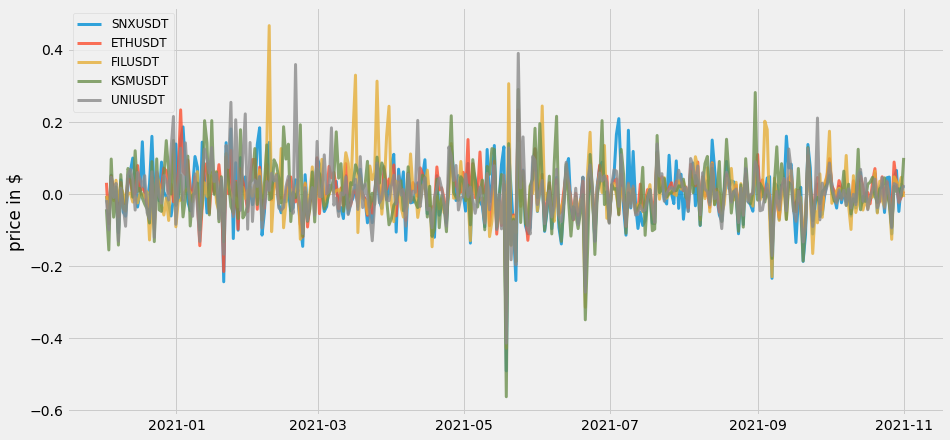

In [294]:

plt.figure(figsize=(14, 7))
for c in daily_returns.columns.values:
    plt.plot(daily_returns.index, daily_returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

Text(0, 0.5, 'Cumulative Returns')

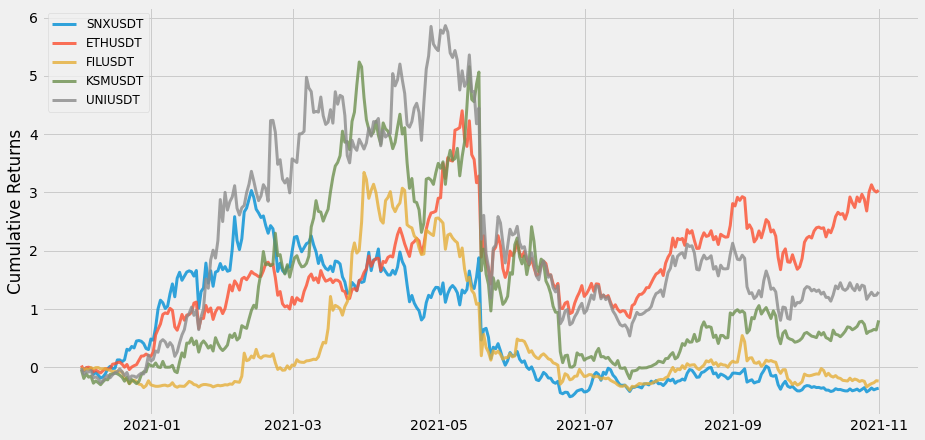

In [295]:
cumulative_ret = (1 + daily_returns).cumprod() - 1
plt.figure(figsize=(14, 7))
for c in cumulative_ret.columns.values:
    plt.plot( cumulative_ret[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Cumulative Returns')

In [296]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=data.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

In [297]:
returns = daily_returns
mean_returns = returns.mean()
#mean_returns
cov_matrix = returns.cov()
corr_matrix = daily_returns.apply(lambda x: np.log(1+x)).corr()


ind_er = data.resample('Y').last().pct_change().mean()
#ind_er
ann_sd = daily_returns.apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))
#ann_sd
#mean_returns
corr_matrix

In [298]:
assets = pd.concat([ind_er, ann_sd], axis=1) # Creating a table for visualising returns and volatility of assets
assets.columns = ['Returns', 'Volatility']
assets

,Returns,Volatility
SNXUSDT,0.241213,1.324271
ETHUSDT,4.925876,0.941027
FILUSDT,1.875289,1.235081
KSMUSDT,4.877204,1.439377
UNIUSDT,4.410428,1.255198


In [299]:
p_ret = [] # Define an empty array for portfolio returns
p_vol = [] # Define an empty array for portfolio volatility
p_weights = [] # Define an empty array for asset weights

num_assets = len(daily_returns.columns)
num_portfolios = 20000
for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, ind_er) # Returns are the product of individual expected returns of asset and its 
                                      # weights 
    p_ret.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
    sd = np.sqrt(var) # Daily standard deviation
    ann_sd = sd*np.sqrt(250) # Annual standard deviation = volatility
    p_vol.append(ann_sd)
    


In [ ]:
data2 = {'Returns':p_ret, 'Volatility':p_vol}
for counter, symbol in enumerate(daily_returns.columns.tolist()):
    #print(counter, symbol)
    data2[symbol+' weight'] = [w[counter] for w in p_weights]
    
portfolios  = pd.DataFrame(data2)

In [ ]:
portfolios.head() # Dataframe of the 10000 portfolios created

,Returns,Volatility,SNXUSDT weight,ETHUSDT weight,FILUSDT weight,KSMUSDT weight,UNIUSDT weight
0,4.176864,1.048271,0.084244,0.166848,0.034233,0.253762,0.460913
1,2.817753,0.970819,0.277900,0.217941,0.230384,0.080704,0.193071
2,3.607183,1.032493,0.044572,0.038038,0.281453,0.163894,0.472042
3,2.997901,0.957232,0.250326,0.272425,0.220671,0.107431,0.149147
4,3.329744,1.000217,0.138975,0.116229,0.243532,0.120419,0.380845


In [ ]:
# Finding the optimal portfolio
rf = 0.01 # risk factor
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
optimal_risky_port


Returns           4.670531
Volatility        0.918050
SNXUSDT weight    0.033902
ETHUSDT weight    0.791578
FILUSDT weight    0.022942
KSMUSDT weight    0.110524
UNIUSDT weight    0.041054
Name: 17701, dtype: float64

In [ ]:
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
# idxmin() gives us the minimum value in the column specified.                               
min_vol_port

Returns           4.169188
Volatility        0.900091
SNXUSDT weight    0.064463
ETHUSDT weight    0.727384
FILUSDT weight    0.140744
KSMUSDT weight    0.020138
UNIUSDT weight    0.047270
Name: 9913, dtype: float64

Text(0, 0.5, 'Annualised Returns (%)')

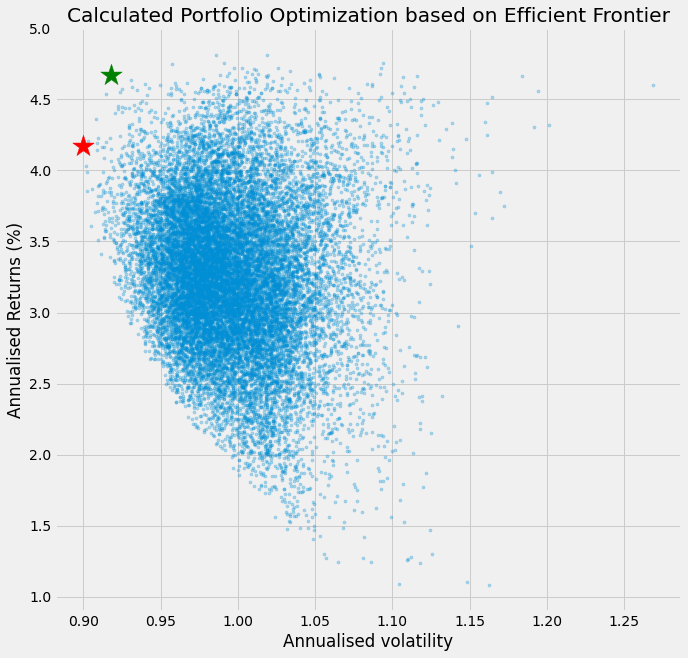

In [ ]:
plt.subplots(figsize=(10, 10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='*', s=500)
plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
plt.xlabel('Annualised volatility')
plt.ylabel('Annualised Returns (%)')